In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
bike_trips = pd.read_csv("Divvy_Trips.csv")
bike_trips['START_TIME'] = pd.to_datetime(bike_trips['START TIME'],format='%m/%d/%Y %I:%M:%S %p').dt.date
bike_trips['STOP_TIME'] = pd.to_datetime(bike_trips['STOP TIME'],format='%m/%d/%Y %I:%M:%S %p').dt.date


In [7]:
bike_trips["START_TIME"].sort_values

<bound method Series.sort_values of 0           2015-12-31
1           2015-12-31
2           2015-12-31
3           2015-12-31
4           2015-12-31
               ...    
21242735    2019-09-30
21242736    2019-09-30
21242737    2019-09-30
21242738    2019-09-30
21242739    2019-09-30
Name: START_TIME, Length: 21242740, dtype: object>

In [8]:
station_data_filtered = pd.read_csv("Divvy_Bicycle_Stations_-_All_-_Map.csv")

In [9]:
station_data_filtered.head()

,ID,Station Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
0,1594046383808271024,Troy St & Jackson Blvd,9,9,In Service,41.877505,-87.704850,"(41.877505, -87.70485)"
1,641,Central Park Ave & Bloomingdale Ave,11,11,In Service,41.914166,-87.716755,"(41.914166, -87.716755)"
2,1683527931525155814,Public Rack - Cornell Ave & 87th Pl,1,1,In Service,41.736881,-87.583146,"(41.73688127, -87.58314552)"
3,367,Racine Ave & 35th St,15,15,In Service,41.830689,-87.656211,"(41.83068856472101, -87.65621066093445)"
4,1673852313397164648,Public Rack - Francisco Ave & Touhy Ave,2,2,In Service,42.011865,-87.701317,"(42.011865, -87.701317)"


In [10]:
station_data_filtered.shape[0]

1419

### Mapping Divvy Stations to respective Community area

1. Get Geographic Boundaries [Polygon] of All Community Areas in Chicago
2. Check if  Geographic point of Divvy lies inside each community area .

In [12]:
import json
with open('Boundaries - Community Areas (current).geojson', 'r') as file:
    coomunity_areas = json.load(file)

In [13]:
from shapely.geometry import shape, Point
ploygonDict = {}
community_station_mapping= {}
for feature in coomunity_areas['features']:
    community_name = feature['properties']['community']
    polygon = shape(feature['geometry'])
    ploygonDict[community_name] = polygon

In [14]:
def get_community_area(row):
    latitude = row.Latitude
    longitude = row.Longitude
    geoPoint = Point(longitude,latitude)
    for community_name, polygon in ploygonDict.items():
        if polygon.contains(geoPoint):
            community_station_mapping[row["Station Name"]] = '_'.join(community_name.strip().split(' '))
            return '_'.join(community_name.strip().split(' '))
        else:
            continue
    return "Not Found"

In [15]:
station_data_filtered['community_area'] = station_data_filtered.apply(lambda x: get_community_area(x), axis=1)
station_data_filtered['community_area']
station_data_filtered.head(5)

,ID,Station Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location,community_area
0,1594046383808271024,Troy St & Jackson Blvd,9,9,In Service,41.877505,-87.704850,"(41.877505, -87.70485)",EAST_GARFIELD_PARK
1,641,Central Park Ave & Bloomingdale Ave,11,11,In Service,41.914166,-87.716755,"(41.914166, -87.716755)",LOGAN_SQUARE
2,1683527931525155814,Public Rack - Cornell Ave & 87th Pl,1,1,In Service,41.736881,-87.583146,"(41.73688127, -87.58314552)",CALUMET_HEIGHTS
3,367,Racine Ave & 35th St,15,15,In Service,41.830689,-87.656211,"(41.83068856472101, -87.65621066093445)",BRIDGEPORT
4,1673852313397164648,Public Rack - Francisco Ave & Touhy Ave,2,2,In Service,42.011865,-87.701317,"(42.011865, -87.701317)",WEST_RIDGE


In [16]:
len(community_station_mapping)

1405

### Find Divvy Traffic for each station
1. Group and Count all From and To Station trips 
2. Add From and To Station count 

In [17]:
from_station_df = bike_trips.groupby('FROM STATION NAME')["FROM STATION NAME"].count()
to_station_df = bike_trips.groupby('TO STATION NAME')["TO STATION NAME"].count()

In [13]:
from_station_df = from_station_df.reset_index(name='from_station_count')
to_station_df = to_station_df.reset_index(name='to_station_count')
from_station_df =  from_station_df.rename(columns={"FROM STATION NAME":"station_name"})
to_station_df =  to_station_df.rename(columns={"TO STATION NAME":"station_name"})
print(from_station_df.head(5))
print(to_station_df.head(5))


                 station_name  from_station_count
0         2112 W Peterson Ave                2351
1               63rd St Beach                5438
2              900 W Harrison                5045
3           900 W Harrison St               27127
4  Aberdeen St & Jackson Blvd               62172
                 station_name  to_station_count
0         2112 W Peterson Ave              2558
1               63rd St Beach              5370
2              900 W Harrison              4602
3           900 W Harrison St             25424
4  Aberdeen St & Jackson Blvd             61196


In [25]:
bike_trips.head()

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,FROM STATION NAME,TO STATION ID,TO STATION NAME,USER TYPE,GENDER,BIRTH YEAR,FROM LATITUDE,FROM LONGITUDE,FROM LOCATION,TO LATITUDE,TO LONGITUDE,TO LOCATION,START_TIME,STOP_TIME
0,8546790,12/31/2015 05:35:00 PM,12/31/2015 05:44:00 PM,979,521,117,Wilton Ave & Belmont Ave,229,Southport Ave & Roscoe St,Subscriber,Female,1991.0,41.940180,-87.653040,POINT (-87.65304 41.94018),41.943739,-87.664020,POINT (-87.66402 41.943739),2015-12-31,2015-12-31
1,8546793,12/31/2015 05:37:00 PM,12/31/2015 05:41:00 PM,1932,256,301,Clark St & Schiller St,138,Clybourn Ave & Division St,Subscriber,Male,1992.0,41.907993,-87.631501,POINT (-87.631501 41.907993),41.904613,-87.640552,POINT (-87.640552 41.904613),2015-12-31,2015-12-31
2,8546795,12/31/2015 05:37:00 PM,12/31/2015 05:40:00 PM,1693,134,465,Marine Dr & Ainslie St,251,Clarendon Ave & Leland Ave,Subscriber,Female,1987.0,41.971600,-87.650154,POINT (-87.650154 41.9716),41.967968,-87.650001,POINT (-87.650001 41.967968),2015-12-31,2015-12-31
3,8546797,12/31/2015 05:38:00 PM,12/31/2015 05:55:00 PM,3370,995,333,Ashland Ave & Blackhawk St,198,Green St (Halsted St) & Madison St,Subscriber,Male,1975.0,41.907066,-87.667252,POINT (-87.667252 41.907066),41.881892,-87.648789,POINT (-87.648789 41.881892),2015-12-31,2015-12-31
4,8546798,12/31/2015 05:38:00 PM,12/31/2015 05:41:00 PM,2563,177,48,Larrabee St & Kingsbury St,111,Sedgwick St & Huron St,Subscriber,Male,1990.0,41.897764,-87.642884,POINT (-87.642884 41.897764),41.894666,-87.638437,POINT (-87.638437 41.894666),2015-12-31,2015-12-31


Sort By Traffic Count and Take Top 5 Community areas

In [26]:
outer_merged = pd.merge(from_station_df, to_station_df, how="inner", on=["station_name"])
outer_merged['traffic'] = outer_merged['from_station_count'] + outer_merged['to_station_count'] 
outer_merged["community_area"] =  outer_merged.apply(lambda x:community_station_mapping.get(x["station_name"]), axis=1)
outer_merged
bike_trips['From_Station_Community_Area'] = bike_trips.apply(lambda x: community_station_mapping.get(x["FROM STATION NAME"]), axis=1)
bike_trips['To_Station_Community_Area'] = bike_trips.apply(lambda x: community_station_mapping.get(x["TO STATION NAME"]), axis=1)
bike_trips.to_csv("divvy_trips_2.csv")

In [15]:

grouped_df_2 =  outer_merged.groupby(["community_area"]).agg({"traffic": "sum"})
grouped_df_2 = grouped_df_2.sort_values("traffic",ascending=False).reset_index()
print(grouped_df_2)
l = grouped_df_2["community_area"][:5]
l

            community_area  traffic
0          NEAR_NORTH_SIDE  7431161
1                     LOOP  6335052
2           NEAR_WEST_SIDE  5108456
3             LINCOLN_PARK  4402832
4                LAKE_VIEW  2860288
5                WEST_TOWN  2553340
6          NEAR_SOUTH_SIDE  1595122
7             LOGAN_SQUARE   924125
8                   UPTOWN   830577
9                HYDE_PARK   622076
10          LINCOLN_SQUARE   485897
11                 DOUGLAS   442277
12               EDGEWATER   420168
13            NORTH_CENTER   377242
14         LOWER_WEST_SIDE   354963
15             ROGERS_PARK   222604
16              BRIDGEPORT   155317
17                 KENWOOD   104900
18                WOODLAWN    98431
19           ARMOUR_SQUARE    92253
20             IRVING_PARK    92032
21                AVONDALE    73843
22             ALBANY_PARK    54401
23         GRAND_BOULEVARD    53826
24              WEST_RIDGE    50821
25           HUMBOLDT_PARK    30554
26          SOUTH_LAWNDALE  

0    NEAR_NORTH_SIDE
1               LOOP
2     NEAR_WEST_SIDE
3       LINCOLN_PARK
4          LAKE_VIEW
Name: community_area, dtype: object

In [16]:

filtered_outer_merged = outer_merged[outer_merged["community_area"].isin(l)]
filtered_grouped_df = filtered_outer_merged.groupby(["community_area","station_name"]).agg({"traffic": "sum"})
filtered_grouped_df

traffic
community_area station_name                           
LAKE_VIEW      Ashland Ave & Belle Plaine Ave    30111
               Ashland Ave & Grace St            52947
               Ashland Ave & Wellington Ave      48484
               Broadway & Barry Ave             175721
               Broadway & Belmont Ave           131046
...                                                ...
NEAR_WEST_SIDE Racine Ave & Randolph St          41710
               Sangamon St & Washington Blvd     41180
               Western Ave & Congress Pkwy       16275
               Western Ave & Monroe St           12230
               Wolcott Ave & Polk St             95378

[199 rows x 1 columns]

In [17]:
filtered_grouped_df_top3 = filtered_grouped_df['traffic'].groupby(["community_area"], group_keys=False).nlargest(3)
filtered_grouped_df_top3

community_area   station_name                
LAKE_VIEW        Wilton Ave & Belmont Ave        218757
                 Broadway & Barry Ave            175721
                 Sheridan Rd & Irving Park Rd    157229
LINCOLN_PARK     Theater on the Lake             516753
                 Clark St & Armitage Ave         248436
                 Clark St & Lincoln Ave          242069
LOOP             Millennium Park                 472836
                 Michigan Ave & Washington St    390925
                 Daley Center Plaza              331391
NEAR_NORTH_SIDE  Streeter Dr & Grand Ave         687996
                 Michigan Ave & Oak St           473714
                 Kingsbury St & Kinzie St        306603
NEAR_WEST_SIDE   Clinton St & Washington Blvd    565881
                 Canal St & Adams St             539462
                 Clinton St & Madison St         474484
Name: traffic, dtype: int64

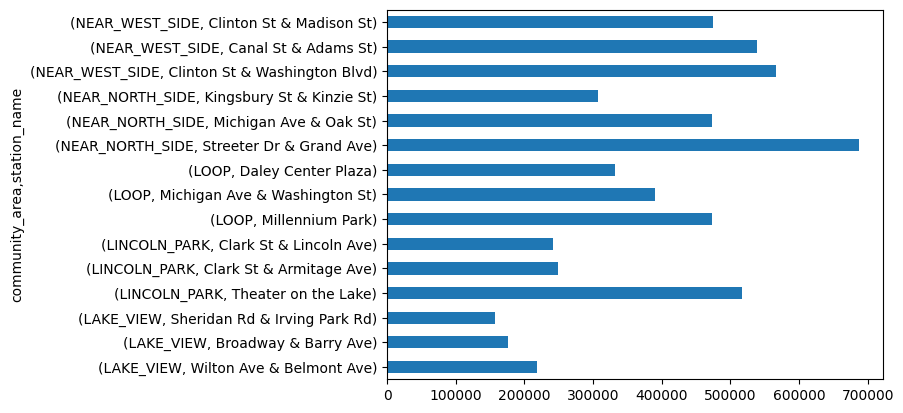

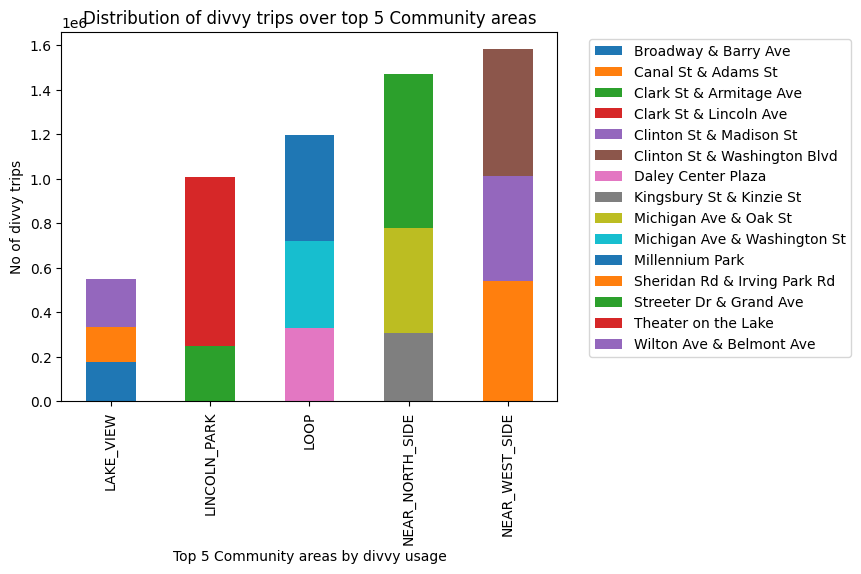

In [18]:
filtered_grouped_df_top3.plot(kind="barh")

filtered_grouped_df_top3.unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of divvy trips over top 5 Community areas')
plt.xlabel('Top 5 Community areas by divvy usage')
plt.ylabel('No of divvy trips')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
